# Per-Decision variance comparison
We want to inspect the differences in variance (by comparing the performances) of vanilla-POIS versus Per-Decision-POIS (PD-POIS).
We start by loading the necessary data from sacred file storage.

In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

First we need to load all the runs from the sacred dataset.

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))

Loaded runs: 572
Loaded final runs: 704


In [3]:
pdisnn_runs_local = load_runs('../sacred_pdisnn/')
print("Loaded pdisnn runs:", len(pdisnn_runs_local.keys()))

Loaded pdisnn runs: 213


In [4]:
# Merge the runs
total_runs = {}
for key, value in final_runs.items():
    total_runs[str(key) + '-final'] = value
for key, value in pdisnn_runs_local.items():
    total_runs[str(key) + '-local'] = value

We also create a base query which will be used throughout this notebook:

In [5]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 1.0,
    'config.clipping': False,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

These properties are common to each experiment here.

## CartPole with 100 episodes
We start by inspecting the CartPole environment, using 100 episodes for each iteration as used in the paper. Since Per-Decision POIS seemed to get stuck in some situations, we also tried to enforce exploration through an entropy bonus. This entropy bonus is given only in the first 100 iterations (over a total of 500 iterations), and is scaled by a factor of 10 (which was found after some experiments).

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 20
Seeds: 245, 746, 712, 545, 178, 689, 963, 247, 481, 236, 100, 947, 315, 153, 15, 950, 307, 662, 42, 8
----------------------------------------
Method: pdis  - Delta: 0.99
Experiments: 19
Seeds: 100, 178, 315, 245, 712, 8, 481, 950, 42, 247, 15, 236, 947, 153, 746, 689, 307, 545, 963


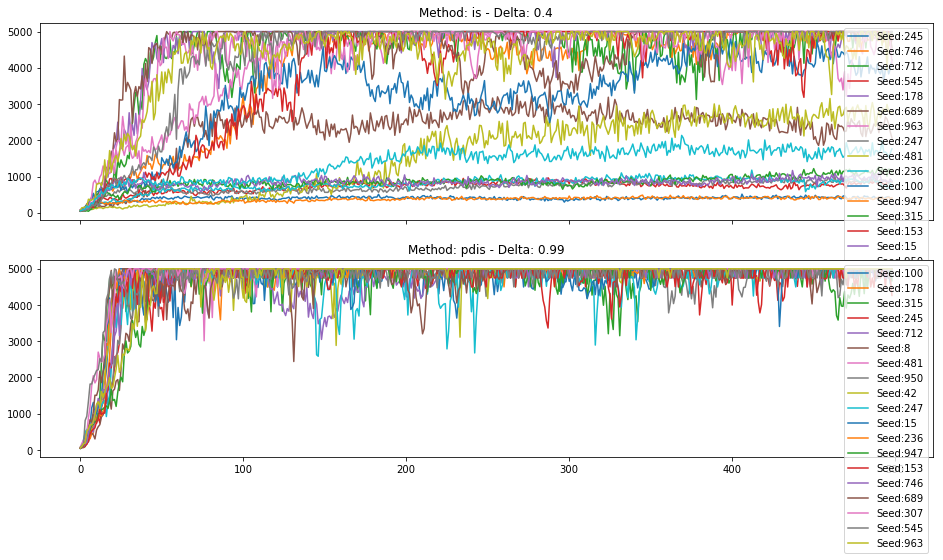

In [6]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2', 0.4),
                                              ('pdis', 'pdis-max-d2', 0.99)]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 20
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

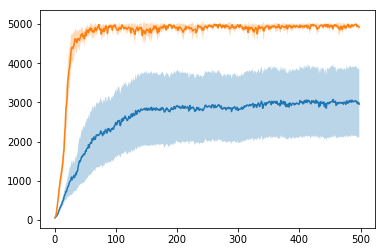

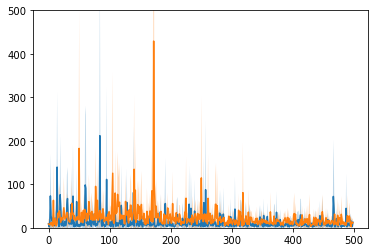

RUN1 std(IW): 27.076172143872828
RUN1 var(J): 6703847779.296874
RUN1 mean(bound): -3740.412872258456
------------
RUN2 std(IW): 17.346237376606776
RUN2 var(J): 4853006048.975755
RUN2 mean(bound): -2039.1652983134463


In [19]:
query1 = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': 'is',
        'config.delta': 0.4,
        'config.bound': 'max-d2',
        'config.num_episodes': 20,
        'config.policy_init': 'zeros'
    }
query2 = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': 'pdis',
        'config.delta': 0.99,
        'config.bound': 'pdis-max-d2',
        'config.num_episodes': 20,
        'config.policy_init': 'zeros'
    }
filtered_runs1 = filter_runs({**base_query, **query1}, total_runs)
filtered_runs2 = filter_runs({**base_query, **query2}, total_runs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs1, 'EpRewMean', axis)
plot_mean_ci(filtered_runs2, 'EpRewMean', axis)
plt.show();
#print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs1, 'StdIW', axis)
plot_mean_ci(filtered_runs2, 'StdIW', axis)
axis.set_ylim(0, 500)
plt.show();

stdIWs = []
variances = []
bounds = []
for run_key, run in filtered_runs1.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    bound = run['metrics']['Bound']['values']
    J = run['metrics']['ReturnMeanIW']['values']
    b = np.array(bound) - np.array(J)
    stdIWs.extend(stdIW)
    variances.extend(variance)
    bounds.extend(b)
print("RUN1 std(IW):", np.mean(stdIWs))
print("RUN1 var(J):", np.mean(variances))
print("RUN1 mean(bound):", np.mean(bounds))

print('------------')
stdIWs = []
variances = []
bounds = []
for run_key, run in filtered_runs2.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    bound = run['metrics']['Bound']['values']
    J = run['metrics']['ReturnMeanIW']['values']
    b = np.array(bound) - np.array(J)
    stdIWs.extend(stdIW)
    variances.extend(variance)
    bounds.extend(b)
print("RUN2 std(IW):", np.mean(stdIWs))
print("RUN2 var(J):", np.mean(variances))
print("RUN2 mean(bound):", np.mean(bounds))

## Inverted pendulum

----------------------------------------
Method: is  - Delta: 0.9
Experiments: 20
Seeds: 481, 15, 153, 963, 315, 950, 42, 8, 100, 545, 236, 662, 307, 178, 712, 245, 247, 947, 746, 689
----------------------------------------
Method: pdis  - Delta: 0.9999
Experiments: 20
Seeds: 42, 15, 315, 307, 481, 8, 689, 178, 712, 247, 746, 963, 545, 245, 947, 950, 153, 662, 100, 236


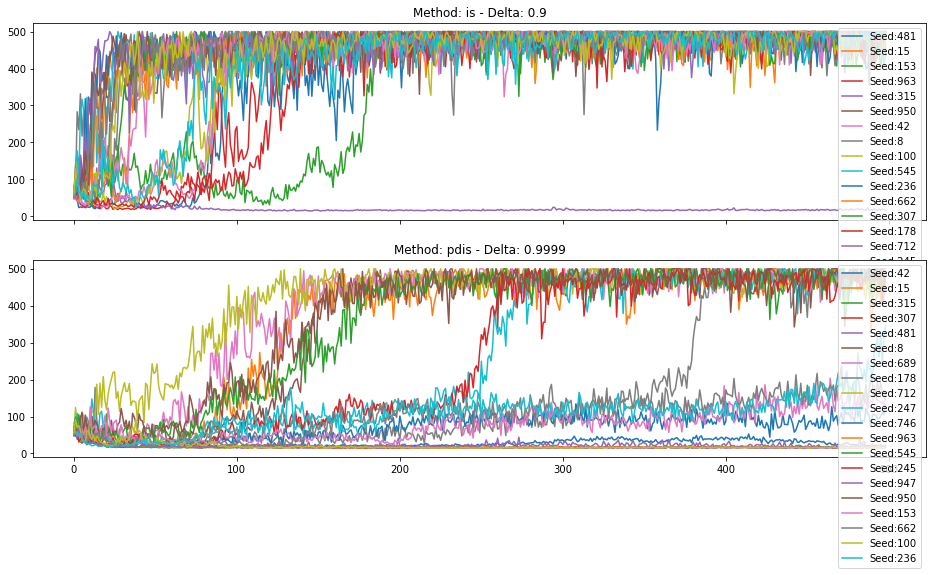

In [25]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2', 0.9),
                                              ('pdis', 'pdis-max-d2', 0.9999)]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 20
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpLenMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

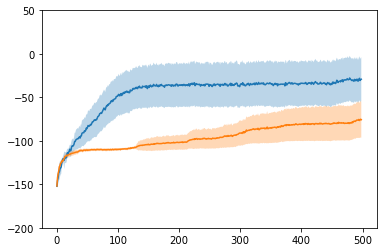

Seeds: 662, 950, 963, 236, 8, 42, 689, 178, 153, 247, 100, 947, 746, 15, 315, 307, 245, 712, 545, 481
RUN1 std(IW): 0.7560027047246695
RUN1 var(J): 8611.651588745117
RUN1 mean(J): 18.092407530323005
RUN2 std(IW): 0.5432814321666956
RUN2 var(J): 3835.168905456543
RUN1 mean(J): 15.91057417404371


In [23]:
query1 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
    }
query2 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': 0.9999,
        'config.bound': 'pdis-max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
    }
filtered_runs1 = filter_runs({**base_query, **query1}, total_runs)
filtered_runs2 = filter_runs({**base_query, **query2}, total_runs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs1, 'EpRewMean', axis)
plot_mean_ci(filtered_runs2, 'EpRewMean', axis)
axis.set_ylim(-200, 50)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs1[key]['config']['seed'] for key in filtered_runs1.keys()])))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs1.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN1 std(IW):", np.mean(stdIWs))
print("RUN1 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs2.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN2 std(IW):", np.mean(stdIWs))
print("RUN2 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

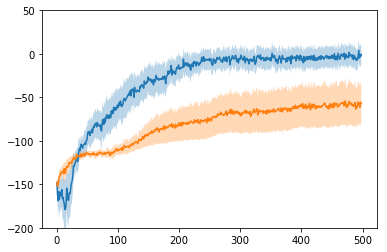

Seeds: 481, 15, 153, 963, 315, 950, 42, 8, 100, 545, 236, 662, 307, 178, 712, 245, 247, 947, 746, 689
RUN1 std(IW): 0.409236500877887
RUN1 var(J): 4136.554880752564
RUN1 mean(J): 23.50171677218518
RUN2 std(IW): 0.36448262332007286
RUN2 var(J): 1864.4903555297851
RUN1 mean(J): 19.447365153524164


In [24]:
query1 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 20,
        'config.policy_init': 'zeros'
    }
query2 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': 0.9999,
        'config.bound': 'pdis-max-d2',
        'config.num_episodes': 20,
        'config.policy_init': 'zeros'
    }
filtered_runs1 = filter_runs({**base_query, **query1}, total_runs)
filtered_runs2 = filter_runs({**base_query, **query2}, total_runs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs1, 'EpRewMean', axis)
plot_mean_ci(filtered_runs2, 'EpRewMean', axis)
axis.set_ylim(-200, 50)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs1[key]['config']['seed'] for key in filtered_runs1.keys()])))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs1.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN1 std(IW):", np.mean(stdIWs))
print("RUN1 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs2.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN2 std(IW):", np.mean(stdIWs))
print("RUN2 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

In [ ]:
total_runs['99-local']['metrics'].keys()